In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
import tables
from scipy import stats

%matplotlib inline

In [2]:
SOTA2015_FIT_ALL = [9.0122372262846735,
 6.5882697680183346,
 -0.77727342693609758,
 -2.1477049943999713,
 0.67132336969927486,
 0.33209623740442562]

In [3]:
SOTA2015_FIT_NO_1P5 = [9.6887121605441173,
 9.1613040261776177,
 -0.41919343599067715,
 -2.3829996965532048,
 0.54998934814773903,
 0.47839260691599156]

In [4]:
SOTA2015_FIT_ONLY_1P5 = [8.541709287866361,
 0.44482688155644085,
 -3.5137852251178465,
 -1.3505424393223699,
 1.5278061271148755,
 0.30973569068842272]

In [5]:
with tables.openFile('/proj/sot/ska/data/acq_stats/acq_stats.h5', 'r') as h5:
    cols = h5.root.data.cols
    names = {'tstart': 'guide_tstart',
             'obsid': 'obsid',
             'obc_id': 'acqid',
             'warm_pix': 'n100_warm_frac',
             'mag': 'mag_aca',
             'known_bad': 'known_bad',
             'color': 'color1'}
    acqs = Table([getattr(cols, h5_name)[:] for h5_name in names.values()],
                 names=list(names.keys()))

    year_q0 = 1999.0 + 31. / 365.25  # Jan 31 approximately
acqs['year'] = Time(acqs['tstart'], format='cxcsec').decimalyear.astype('f4')
acqs['quarter'] = (np.trunc((acqs['year'] - year_q0) * 4)).astype('f4')
acqs['fail'] = 1.0 - acqs['obc_id'].astype(np.int)
acqs['color_1p5'] = np.where(acqs['color'] == 1.5, 1, 0)

In [62]:
data_all = acqs.group_by('quarter')
data_all['mag10'] = data_all['mag'] - 10.0
data_all.sort('year')
ok = (data_all['year'] > 2007) & (data_all['mag'] > 8.5) & (data_all['mag'] < 11.0)
data_all = data_all[ok]
data_all = data_all.group_by('quarter')
data_mean = data_all.groups.aggregate(np.mean)

ok = np.ones(len(data_all), dtype=bool)
print('Filtering known bad obsids, start len = {}'.format(len(data_all)))
bad_obsids = [
    # Venus
    2411,2414,6395,7306,7307,7308,7309,7311,7312,7313,7314,7315,7317,7318,7406,583,
    7310,9741,9742,9743,9744,9745,9746,9747,9749,9752,9753,9748,7316,15292,16499,
    16500,16501,16503,16504,16505,16506,16502,
    ]
for badid in bad_obsids:
    ok = ok & (data_all['obsid'] != badid)
data_all = data_all[ok]
print('Filtering known bad obsids, end len = {}'.format(len(data_all)))

Filtering known bad obsids, start len = 75491
Filtering known bad obsids, end len = 75385


In [63]:
# SET DATA FILTERING for this run
# data_all = data_all[data_all['color'] == 1.5]
data_all

obc_id,known_bad,tstart,color,warm_pix,mag,obsid,year,quarter,fail,color_1p5,mag10
bool,bool,float64,float64,float64,float64,int64,float32,float32,float64,int64,float64
True,False,284017659.681,1.47899985313,0.037536239405,8.92266273499,58613,2007.0,31.0,0.0,0,-1.07733726501
True,False,284017659.681,1.04379975796,0.037536239405,8.83009433746,58613,2007.0,31.0,0.0,0,-1.16990566254
True,False,284017659.681,1.49089980125,0.037536239405,9.53129386902,58613,2007.0,31.0,0.0,0,-0.468706130981
True,False,284017659.681,0.59840041399,0.037536239405,9.28877162933,58613,2007.0,31.0,0.0,0,-0.711228370667
True,False,284017659.681,0.231200262904,0.037536239405,8.9228105545,58613,2007.0,31.0,0.0,0,-1.0771894455
True,False,284017659.681,1.10670006275,0.037536239405,9.7141456604,58613,2007.0,31.0,0.0,0,-0.2858543396
True,False,284017659.681,1.5,0.037536239405,9.73987197876,58613,2007.0,31.0,0.0,1,-0.26012802124
True,False,284019533.381,0.909499764442,0.0375113319633,8.96426963806,58612,2007.0,31.0,0.0,0,-1.03573036194
True,False,284019533.381,0.473450124264,0.0375113319633,9.33366012573,58612,2007.0,31.0,0.0,0,-0.666339874268


In [64]:
def scaled_warm_frac(pars, x, data=None, mag=None, wp=None):
    if data is None:
        data = data_all
        
    m10 = data['mag10'] if mag is None else mag - 10.0
    if wp is None:
        wp = data['warm_pix']
        
    scl0, scl1, scl2 = pars[0:3]
    off0, off1, off2 = pars[3:6]
    
    scale = scl0 + scl1 * m10 + scl2 * m10**2
    offset = off0 + off1 * m10 + off2 * m10**2  # + off_color1p5 * acq_data['color_1p5']
    
    model_fail = offset + scale * wp
    model_fail = stats.norm.cdf(model_fail)  # probit transform
    return model_fail

In [65]:
def fit_sota_model():
    from sherpa import ui

    data_id = 1
    ui.set_method('simplex')
    ui.set_stat('cash')
    ui.load_user_model(scaled_warm_frac, 'model')
    ui.add_user_pars('model', ['scl0', 'scl1', 'scl2', 'off0', 'off1', 'off2'])
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id, np.array(data_all['year']), np.array(data_all['fail'], dtype=np.float))

    # Initial fit values from SOTA 2013 presentation (modulo typo there)
    start_vals = iter(SOTA2015_FIT_ALL)  # Offset
    fmod = ui.get_model_component('model')
    for name in ('scl', 'off'):
        for num in (0, 1, 2):
            comp_name = name + str(num)
            setattr(fmod, comp_name, start_vals.next())
            comp = getattr(fmod, comp_name)
            comp.min = -100000
            comp.max = 100000
            # ui.freeze(comp)
    
    ui.fit(data_id)
    # conf = ui.get_confidence_results()
    return ui.get_fit_results()

In [66]:
def plot_fit_grouped(pars, group_col, group_bin, mask=None, log=False, colors='br', label=None):
    if mask is None:
        mask = np.ones(len(data_all), dtype=bool)
    data = data_all[mask]
    data['model'] = scaled_warm_frac(pars, None, data)

    group = np.trunc(data[group_col] / group_bin)
    data = data.group_by(group)
    data_mean = data.groups.aggregate(np.mean)
    len_groups = np.diff(data.groups.indices)
    fail_sigmas = np.sqrt(data_mean['fail'] * len_groups) / len_groups
    
    plt.errorbar(data_mean[group_col], data_mean['fail'], yerr=fail_sigmas, fmt='.' + colors[0], label=label)
    plt.plot(data_mean[group_col], data_mean['model'], '-' + colors[1])
    if log:
        ax = plt.gca()
        ax.set_yscale('log')

In [67]:
def mag_filter(mag0, mag1):
    ok = (data_all['mag'] > mag0) & (data_all['mag'] < mag1)
    return ok

In [68]:
def wp_filter(wp0, wp1):
    ok = (data_all['warm_pix'] > wp0) & (data_all['warm_pix'] < wp1)
    return ok

In [69]:
print('Hang tight, this will take a few minutes')
fit = fit_sota_model()

Hang tight, this will take a few minutes
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 23657.2
Final fit statistic   = 23647.6 at function evaluation 904
Data points           = 75385
Degrees of freedom    = 75379
Change in statistic   = 9.57962
   model.scl0     9.01224     
   model.scl1     6.58827     
   model.scl2     -0.777273   
   model.off0     -2.1477     
   model.off1     0.671323    
   model.off2     0.332096    


INFO:sherpa.ui.utils:Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 23657.2
Final fit statistic   = 23647.6 at function evaluation 904
Data points           = 75385
Degrees of freedom    = 75379
Change in statistic   = 9.57962
   model.scl0     9.01224     
   model.scl1     6.58827     
   model.scl2     -0.777273   
   model.off0     -2.1477     
   model.off1     0.671323    
   model.off2     0.332096    


In [70]:
print(fit)

datasets       = (1,)
itermethodname = none
methodname     = neldermead
statname       = cash
succeeded      = True
parnames       = ('model.scl0', 'model.scl1', 'model.scl2', 'model.off0', 'model.off1', 'model.off2')
parvals        = (9.0122372262846735, 6.5882697680183346, -0.77727342693609758, -2.1477049943999713, 0.67132336969927486, 0.33209623740442562)
statval        = 23647.61329
istatval       = 23657.1929139
dstatval       = 9.57962396379
numpoints      = 75385
dof            = 75379
qval           = None
rstat          = None
message        = Optimization terminated successfully
nfev           = 904


In [71]:
parvals = [par.val for par in model.pars]
parvals

[9.0122372262846735,
 6.5882697680183346,
 -0.77727342693609758,
 -2.1477049943999713,
 0.67132336969927486,
 0.33209623740442562]

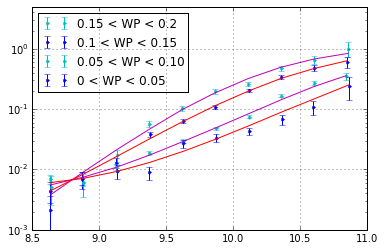

In [72]:
plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.15, 0.20), log=True, colors='cm', label='0.15 < WP < 0.2')
plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.10, 0.15), log=True, colors='br', label='0.1 < WP < 0.15')
plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.05, 0.10), log=True, colors='cm', label='0.05 < WP < 0.10')
plot_fit_grouped(parvals, 'mag', 0.25, wp_filter(0.0, 0.05), log=True, colors='br', label='0 < WP < 0.05')
plt.legend(loc='best');
plt.ylim(0.001, 5);
plt.grid();

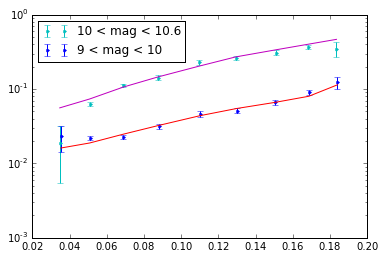

In [73]:
plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(10, 10.6), log=True, colors='cm', label='10 < mag < 10.6')
plot_fit_grouped(parvals, 'warm_pix', 0.02, mag_filter(9, 10), log=True, colors='br', label='9 < mag < 10')
plt.legend(loc='best');

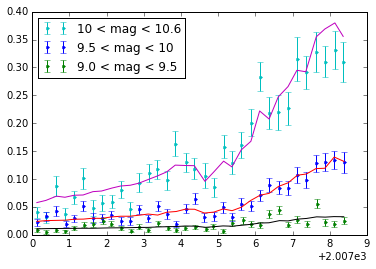

In [74]:
plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.6), colors='cm', label='10 < mag < 10.6')
plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10), colors='br', label='9.5 < mag < 10')
plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5),  colors='gk', label='9.0 < mag < 9.5')
plt.legend(loc='best');

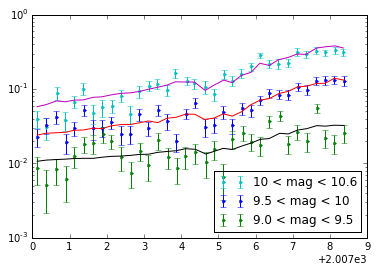

In [75]:
plot_fit_grouped(parvals, 'year', 0.25, mag_filter(10, 10.6), colors='cm', label='10 < mag < 10.6', log=True)
plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.5, 10), colors='br', label='9.5 < mag < 10', log=True)
plot_fit_grouped(parvals, 'year', 0.25, mag_filter(9.0, 9.5),  colors='gk', label='9.0 < mag < 9.5', log=True)
plt.legend(loc='best');

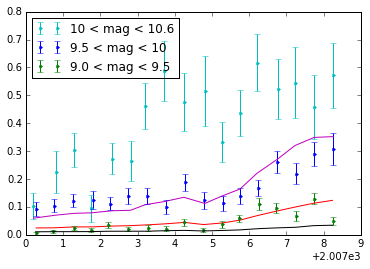

In [76]:
ok = data_all['color'] == 1.5
if np.any(ok):
    plot_fit_grouped(parvals, 'year', 0.5, mag_filter(10, 10.6) & ok, colors='cm', label='10 < mag < 10.6')
    plot_fit_grouped(parvals, 'year', 0.5, mag_filter(9.5, 10) & ok, colors='br', label='9.5 < mag < 10')
    plot_fit_grouped(parvals, 'year', 0.5, mag_filter(9.0, 9.5) & ok,  colors='gk', label='9.0 < mag < 9.5')
    plt.legend(loc='best');

In [77]:
model.pars

(<Parameter 'scl0' of model 'model'>,
 <Parameter 'scl1' of model 'model'>,
 <Parameter 'scl2' of model 'model'>,
 <Parameter 'off0' of model 'model'>,
 <Parameter 'off1' of model 'model'>,
 <Parameter 'off2' of model 'model'>)

In [78]:
parvals

[9.0122372262846735,
 6.5882697680183346,
 -0.77727342693609758,
 -2.1477049943999713,
 0.67132336969927486,
 0.33209623740442562]